# Capstone Project - The Battle of the Neighborhoods
### Buying an apartment in Hamburg, Germany

<img src="https://www.maxpixel.net/static/photo/2x/Alster-Abendstimmung-Jungfernstieg-Hamburg-2147675.jpg">

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project I will try to solve the problem of finding an optimal housing object/location in Hamburg, Germany.
In particular this project will be aimed at the potential buyers of a housing object in Hamburg, Germany. I will limit this housing object to apartments for sale in Hamburg and the target group would be newlyweds, couples or families with children under 10 years old.

The real estate market in Hamburg is notorious for its soaring price over years. The total area of Hamburg is 755,1 square kilometres. There are 7 districts (Altona, Bergedorf, Eimsbüttel, Harburg, Hamburg-Mitte, Hamburg-Nord, Wandsbek) and 104 smaller quarters that are allocated to those 7 districts. The definition of Hamburg is restricted strictly to the political defined region and not the greater Hamburg Metropolitan area that includes other German federal states such as Schleswig-Holstein and Lower Saxony (Niedersachen), which are the adjoining states of Hamburg.

Given that there are more than 23,000 streets in Hamburg, I will aim at some certain quarters, exploring the neighborhoods and using the Foursquare API to analyze the common venues in a particular quarter. To make the sales data of apartments in Hamburg more sophisticated, I will use web scrapping techniques to analyze the all the listing advertisements on ImmobilienScout24.de, which is the biggest real estate online platform in Germany. The goal of this capstone project is to recommend young families or couples find an optimal housing object, in this case an apartment, in Hamburg, Germany.

I will use data science analytics to generate some most promising areas based on those criteria. Advantages of each area will then be clearly expressed so that best possible final locations can be chosen by potential targeted buyers.

## Data <a name="data"></a>

Based on definition of the business problem, factors that will influence the discussion are:

- All the street data and their matching boroughs in Hamburg
- The statistical result of overall living quality in all streets in Hamburg area
- The characteristics of apartments available for sale in Hamburg
- Most common venues in a certain neighborhood/borough in Hamburg

Following data sources will be needed to extract/generate the required information:

- **Official Data** from Hamburg government and Statistics office for Hamburg and Schleswig-Holstein
- Characteristics of apartments for sales in Hamburg (as of July 2019) will be retrieved by using **Beautiful Soup** to complete the webscrapping of immobilienscout24.de
- Using the python library **Pandas** to retrieve the basic neighborhodd data from Wikipedia page.
- Important venues in a certain borough in Hamburg will be obtained by using **Foursquare API**

### Official statistical data from government

#### 1. Living quality for rent index 2017 ####
The city-state government of Hamburg published a list containing all the streets and their grades of living quality for the rent index in 2017. This is the most actual data available from the government. There are only two labels for a street, either the living quality is "gut"(English: good) or "normal" (English: normal). Of course, we Germans love to categorize things, so besides the good or normal comment, there is a score for each street in Hamburg. This score is based on six big categories, like the borough status (land value, citizen structure...,etc), grassy area, population density, you name it. The fine line between a street with "good" or "normal" living quality lies in the score of -0,575. However, the contracted company for conducting this survey admitted that the criteria "centrality" (how close is this street to the city centre) and "tree population" (the private own trees could not be measured properly...) are not considered.

The complete list in German could be download [here](https://www.hamburg.de/contentblob/10020798/e9ae9a0b62cd2f5b86cdd7f7df48dd74/data/d-wohnlagenverzeichnis-2017.pdf).

#### 2. All the street data and their matching boroughs in Hamburg ####

The Federal Statistics Office for Hamburg and Schleswig-Holstein (Statistikamt Nord) has plenty of interesting statistics for the two states (Hamburg and Schleswig-Holstein) in the northern Germany. The latest published version online is in January, 2017. The complete list in German could be download [here](https://www.statistik-nord.de/fileadmin/Dokumente/Verzeichnisse/SGV_Hamburg_2011_Siebente_Auflage.pdf).

Finally, I combined the data sheets from 1 and 2 and created a new raw data, which join the two tables on the _street_ name "Strasse" and attached the _"quarter"_ tag "Stadtteil" to the living quality table. I dropped all the streets which are actually bridges (German: bruecken), since there are no scores for such an address. (You may live under the bridge for free without renting it or buying it legally....).

*Note*: 
###### 1. The original file of Data 1 contains a typo "kßlmßstraße" should be "kálmánstraße". I adjusted this entry manually. 
###### 2. Between 2017 and 2019 there are some new streets in Hamburg, mostly in Neugraben-Fischbek and Kirchwerder or around the port area. This is also adjusted manually.

In [50]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.') 

df_qual = pd.read_csv('https://raw.githubusercontent.com/bekyl/Coursera_Capstone/master/Strassen_Stadtteil_Wohnlage_HH.csv', sep=';')

print ('And data read into a pandas dataframe!')

Libraries imported.
And data read into a pandas dataframe!


In [51]:
df_qual.shape

(23163, 7)

In [52]:
df_qual.head()

,Strasse,Hausnr1,Hausnr2,Art,Wohnlage,Wohnlagenkennwert,Stadtteil
0,1. Hafenstrasse,1,-1,U,normal,"-21,282",Heimfeld
1,Aalheitengraben,1,-3,U,gut,"2,06",Volksdorf
2,Aalheitengraben,4,-14,G,gut,"1,767",Volksdorf
3,Aalkrautweg,1,-35,U,gut,"4,675",Sasel
4,Aalkrautweg,2,-58,G,gut,"4,72",Sasel


In [53]:
pd.value_counts(df_qual['Wohnlage'].values, sort=False)

normal    15381
gut        7782
dtype: int64

In [54]:
# Let's remove the streets with the "normal" living quality from the data frame
df_gut=df_qual[df_qual.Wohnlage != 'normal']
df_gut.head()

,Strasse,Hausnr1,Hausnr2,Art,Wohnlage,Wohnlagenkennwert,Stadtteil
1,Aalheitengraben,1,-3,U,gut,"2,06",Volksdorf
2,Aalheitengraben,4,-14,G,gut,"1,767",Volksdorf
3,Aalkrautweg,1,-35,U,gut,"4,675",Sasel
4,Aalkrautweg,2,-58,G,gut,"4,72",Sasel
5,Aalort,1,-13,U,gut,"3,075",Sasel


In [55]:
# Now, I'll count how many "good" streets in a certain borough "Stadtteil" and list the top five good quarters

df2=df_gut.groupby(['Stadtteil']).count()
df2.Strasse.sort_values(ascending=False).head()

Stadtteil
Sasel            528
Blankenese       494
Volksdorf        433
Niendorf         419
Poppenbuettel    402
Name: Strasse, dtype: int64

To sum it up, according to the governmental statistical data, the best quarters with the most "good" streets to be dewelled in Hamburg would be **Sasel**, **Blankenese** and **Volksdorf**, regardless of the current housing objects availble for sales.

### Characteristics of appartments for sales in Hamburg (Immobilienscout24)

First of all, I need to give credit to balzer82 on Github. He shared a "immoscraper" on Github, so the data could be easily scrapped from the immobilienscout24's website. (check out his sharing link: https://github.com/balzer82/immoscraper/blob/master/immoscraper.ipynb)

I used the scrapper to obtain the data available on immobilienscout24.de for all apartments for sale in Hamburg, Germany.
There are 825 objects for sale and the data is saved as a csv file.

In [56]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df_immo = pd.read_csv('https://raw.githubusercontent.com/bekyl/Coursera_Capstone/master/2019-07-03-Wohnung-Kauf.csv', sep =";")
                      
print ('Data read into a pandas dataframe!')

Data read into a pandas dataframe!


In [57]:
df_immo.head()

,ID,Haus/Wohnung,ID.1,Miete/Kauf,address,balcony,builtInKitchen,city,floorplan,from,garden,lat,livingSpace,lon,numberOfRooms,postcode,price,privateOffer,quarter,title,url
0,112058772,Wohnung,112058772,Kauf,"Sülldorf, Hamburg",False,True,Hamburg,True,001.455647,True,NaN,81.00,NaN,3.5,22589,375000.0,False,Sülldorf,Ruhiges Wohnen mit Terrasse in Südausrichtung,https://www.immobilienscout24.de/expose/112058772
1,112262603,Wohnung,112262603,Kauf,"Haydnstraße 11, Bahrenfeld, Hamburg",False,False,Hamburg,True,001.9255274,False,53.56741,60.47,9.90468,2.0,22761,435000.0,False,Bahrenfeld,Moderne 2-Zimmer-Wohnung mit sonniger Dachterr...,https://www.immobilienscout24.de/expose/112262603
2,112262602,Wohnung,112262602,Kauf,"Haydnstraße 11, Bahrenfeld, Hamburg",False,False,Hamburg,True,001.9255274,False,53.56741,75.75,9.90468,2.0,22761,546000.0,False,Bahrenfeld,Sonnige Dachterrasse und hochwertige Ausstattu...,https://www.immobilienscout24.de/expose/112262602
3,108374061,Wohnung,108374061,Kauf,"Sophienterrasse 14, Harvestehude, Hamburg",True,False,Hamburg,True,002.01000718389,False,53.57615,257.04,9.99628,4.0,20149,4401000.0,False,Harvestehude,Herzen höher schlagen lassen: Maisonette-Penth...,https://www.immobilienscout24.de/expose/108374061
4,109383549,Wohnung,109383549,Kauf,"Sophienterrasse 14, Harvestehude, Hamburg",True,False,Hamburg,True,002.01000718389,False,53.57615,282.31,9.99628,5.0,20149,4238000.0,False,Harvestehude,Einzig aber nicht artig: Top-Roof im Sophienpa...,https://www.immobilienscout24.de/expose/109383549


In [58]:
## Let's create an extra column called Average Price (Euro per squared meter= €/m²)
df_immo['Average_Price'] = df_immo['price']/df_immo['livingSpace']
df_avg = df_immo.sort_values(by ='quarter',ascending=True).reset_index(drop=True)

df_avg.drop(['Miete/Kauf','city','balcony','address','builtInKitchen','floorplan','from','garden','lat','lon','privateOffer','title','url'], inplace=True, axis=1)
df_avg.head()

,ID,Haus/Wohnung,ID.1,livingSpace,numberOfRooms,postcode,price,quarter,Average_Price
0,93372093,Wohnung,93372093,100.00,3.0,21035,429900.0,Allermöhe,4299.000000
1,112218717,Wohnung,112218717,74.59,3.0,21035,219000.0,Allermöhe,2936.050409
2,110819394,Wohnung,110819394,69.00,2.0,22297,335000.0,Alsterdorf,4855.072464
3,111470722,Wohnung,111470722,82.00,3.0,22297,629000.0,Alsterdorf,7670.731707
4,112246390,Wohnung,112246390,89.35,4.0,22337,425000.0,Alsterdorf,4756.575266


In [96]:
df2 = df_avg[df_avg.quarter=="Blankenese"] 
# Let's group one quarter and calculate the mean of average prices of all listed objects.
# Blankense is known as a quarter for the well-off residents in Hamburg
blankenese = round(df2.price.mean(),2)
print ('The average price € per square meter in Blankenese is %d' % blankenese) 

The average price € per square meter in Blankenese is 1316416


In [95]:
all_quarters = df_avg.quarter.unique()

df_new = []

for elem in all_quarters:
    df_new.append( [elem, round(df_avg[df_avg.quarter==elem].price.mean(),2)])

df_new = pd.DataFrame([i for i in df_new for i in df_new])
df_new.columns = ["Quarter", "average price (€/m²)"]
# Now we have a data frame for the average price per square meter of all housing objects gruped by quarter
df_new.head()

,Quarter,average price (€/m²)
0,Allermöhe,324450.0
1,Alsterdorf,442375.0
2,Altona-Altstadt,816600.0
3,Altona-Nord,540000.0
4,Bahrenfeld,394241.5


In [61]:
df_whg=df_immo.groupby(['quarter']).count() # "quarter" means "Stadtteil" in German
df_whg.ID.sort_values(ascending=False).head()

quarter
Rahlstedt     54
Winterhude    43
Niendorf      28
Eimsbüttel    28
Tonndorf      22
Name: ID, dtype: int64

Now we have some basic data about quarters "Stadtteile" in Hamburg. Let's create a data frame for all the quarters and the representing boroughs in Hamburg with their geolocations for the battle of neighborhoods chosen from the top three quarters in the lists above **Sasel,  Blankenese,  Volksdorf, Rahlstedt, Winterhude, Niendorf and Eimsbüttel** in Hamburg.

In [62]:
## Webscrapping from Wikipedia - Information about quarters and boroughs in Hamburg
# Using the Panda library instead of Beautiful Soup

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
#! pip install lxml 
# The kernel I used kept warning me about not having lxml installed, even though I tested many times in localhost.

array = pd.read_html("https://de.wikipedia.org/wiki/Liste_der_Bezirke_und_Stadtteile_Hamburgs")

hh_list = pd.DataFrame(array[1]) ## Only the second table of this wikipedia page is needed

hh_list.head()

,Stadtteil,Ortsteile,Bezirk,Fläche(km²),Einwohner,Bevölkerungsdichte(Einwohner/km²),Koordinaten,Karte
0,Hamburg-Altstadt,NaN,Hamburg-Mitte,NaN,2272.000,947,"53° 33′ 0″ N, 10° 0′ 0″ O",NaN
1,HafenCity,NaN,Hamburg-Mitte,NaN,4592.000,2087,"53° 32′ 28″ N, 10° 0′ 1″ O",NaN
2,Neustadt,NaN,Hamburg-Mitte,NaN,12.920,5617,"53° 33′ 7″ N, 9° 59′ 8″ O",NaN
3,St. Pauli,NaN,Hamburg-Mitte,NaN,22.436,8974,"53° 33′ 25″ N, 9° 57′ 50″ O",NaN
4,St. Georg,NaN,Hamburg-Mitte,NaN,11.384,4743,"53° 33′ 18″ N, 10° 0′ 44″ O",NaN


In [63]:
list(hh_list.columns.values)

['Stadtteil',
 'Ortsteile',
 'Bezirk',
 'Fläche(km²)',
 'Einwohner',
 'Bevölkerungsdichte(Einwohner/km²)',
 'Koordinaten',
 'Karte']

In [64]:
## Let's remove unnessary columns and add the geographical latitudes and altitudes to the Hamburg quarter list
hh_list.drop(['Ortsteile','Fläche(km²)','Karte','Koordinaten'], inplace=True, axis=1)

In [65]:
hh_list.head()

,Stadtteil,Bezirk,Einwohner,Bevölkerungsdichte(Einwohner/km²)
0,Hamburg-Altstadt,Hamburg-Mitte,2272.000,947
1,HafenCity,Hamburg-Mitte,4592.000,2087
2,Neustadt,Hamburg-Mitte,12.920,5617
3,St. Pauli,Hamburg-Mitte,22.436,8974
4,St. Georg,Hamburg-Mitte,11.384,4743


In [66]:
## Change the column names in German to English
hh_list.rename({'Stadtteil': 'Quarter', 'Bezirk': 'Borough','Einwohner': 'Population',
                'Bevölkerungsdichte(Einwohner/km²)': 'Density(Population/km²)'}, 
               axis=1, inplace=True)
hh_list

,Quarter,Borough,Population,Density(Population/km²)
0,Hamburg-Altstadt,Hamburg-Mitte,2272.000,947
1,HafenCity,Hamburg-Mitte,4592.000,2087
2,Neustadt,Hamburg-Mitte,12.920,5617
3,St. Pauli,Hamburg-Mitte,22.436,8974
4,St. Georg,Hamburg-Mitte,11.384,4743
5,Hammerbrook,Hamburg-Mitte,4323.000,1441
6,Borgfelde,Hamburg-Mitte,7696.000,9620
7,Hamm,Hamburg-Mitte,38.773,9693
8,Horn,Hamburg-Mitte,38.799,6576
9,Billstedt,Hamburg-Mitte,70.355,4139


In [67]:
## Select those seven finalists above from the quarters with the most "good" streets for the battle of neighborhoods

finalist = ['Sasel', 'Blankenese' , 'Volksdorf' , 'Rahlstedt', 'Winterhude','Niendorf', 'Eimsbüttel']
Quarter_selected = hh_list.loc[hh_list['Quarter'].isin(finalist)]
Quarter_selected = Quarter_selected.reset_index(drop=True)
Quarter_selected

,Quarter,Borough,Population,Density(Population/km²)
0,Blankenese,Altona,13.686,1777
1,Eimsbüttel,Eimsbüttel,58.196,17635
2,Niendorf,Eimsbüttel,40.717,3284
3,Winterhude,Hamburg-Nord,55.900,7355
4,Sasel,Wandsbek,23.778,2831
5,Volksdorf,Wandsbek,20.863,1799
6,Rahlstedt,Wandsbek,91.740,3449


In [68]:
#df_new_avg = df_new["average price (€/m²)"]

#Quarter_selected["Average Price"] = df_new.Quarter.map(df_new["average price (€/m²)"])
#Quarter_selected["Average Price"] = df_new.Quarter.map(df_new_avg)

Quarter_selected.merge(df_new, on="Quarter", how="inner").drop_duplicates()

,Quarter,Borough,Population,Density(Population/km²),average price (€/m²)
0,Blankenese,Altona,13.686,1777,1316416.67
79,Eimsbüttel,Eimsbüttel,58.196,17635,482137.86
158,Niendorf,Eimsbüttel,40.717,3284,313707.14
237,Winterhude,Hamburg-Nord,55.900,7355,841109.33
316,Sasel,Wandsbek,23.778,2831,579433.33
395,Volksdorf,Wandsbek,20.863,1799,517406.25
474,Rahlstedt,Wandsbek,91.740,3449,299392.59


In [69]:
! pip install geopy 
# The problem of not having geopy pops up when I use different kernels on the CC lab. 
# In case the codes are not running, I put the installation code of Geopy here.

from geopy.geocoders import Nominatim
geolocator = Nominatim()
Quarter_selected['Coordinates'] = Quarter_selected['Quarter'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
Quarter_selected[['Latitude', 'Longitude']] = Quarter_selected['Coordinates'].apply(pd.Series)
Quarter_selected

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


,Quarter,Borough,Population,Density(Population/km²),Coordinates,Latitude,Longitude
0,Blankenese,Altona,13.686,1777,"(53.5575, 9.80306)",53.557500,9.803060
1,Eimsbüttel,Eimsbüttel,58.196,17635,"(53.5724835, 9.9501)",53.572483,9.950100
2,Niendorf,Eimsbüttel,40.717,3284,"(53.6284111, 9.9557091)",53.628411,9.955709
3,Winterhude,Hamburg-Nord,55.900,7355,"(53.5963901, 10.0038317)",53.596390,10.003832
4,Sasel,Wandsbek,23.778,2831,"(53.6522, 10.1169)",53.652200,10.116900
5,Volksdorf,Wandsbek,20.863,1799,"(53.6485554, 10.1647514)",53.648555,10.164751
6,Rahlstedt,Wandsbek,91.740,3449,"(53.6038827, 10.1581547)",53.603883,10.158155


In [70]:
# Let's get Hamburg's Latitude and Longitude 

from geopy.geocoders import Nominatim 
address = 'Hamburg'

geolocator = Nominatim(user_agent="Hamburg_explorer")
location = geolocator.geocode(address)
Hamburg_latitude = location.latitude
Hamburg_longitude = location.longitude
print('The geograpical coordinates of Hamburg, Germany are {}, {}.'.format(Hamburg_latitude, Hamburg_longitude))

The geograpical coordinates of Hamburg, Germany are 53.550341, 10.000654.


In [71]:
import folium
# create map of Six quarters for our battle of neighborhodds using latitude and longitude values
hh_finalist = folium.Map(location=[Hamburg_latitude, Hamburg_longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(Quarter_selected['Latitude'], Quarter_selected['Longitude'], 
                           Quarter_selected['Quarter']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=9,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(hh_finalist)  
    
hh_finalist

## Methodology <a name="methodology"></a>

### Foursquare

Using Foursquare API to get info about venues in selected quarters in Hamburg. 

In [72]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [73]:
CLIENT_ID = 'KJP3HE521VSWTMRH51CJTTXKEBRESASUYUB1BRSVEEL5A3EY' # your Foursquare ID
CLIENT_SECRET = 'XDNHWQZNMX0A4VVFJJAG0M4V0RIX2S3LJ11AJ4ZDNACHE4UI' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KJP3HE521VSWTMRH51CJTTXKEBRESASUYUB1BRSVEEL5A3EY
CLIENT_SECRET:XDNHWQZNMX0A4VVFJJAG0M4V0RIX2S3LJ11AJ4ZDNACHE4UI


In [74]:
# @hidden_cell 
CLIENT_ID = 'KJP3HE521VSWTMRH51CJTTXKEBRESASUYUB1BRSVEEL5A3EY' 
CLIENT_SECRET = 'XDNHWQZNMX0A4VVFJJAG0M4V0RIX2S3LJ11AJ4ZDNACHE4UI' 
VERSION = '20180604' 

In [75]:
address = 'Hamburg, Germany'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

53.550341 10.000654


In [76]:
radius = 1000
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'Dist_Latitude', 
                  'Dist_Longitude', 
                  'Venue', 
                  'Venue_Lat', 
                  'Venue_Long', 
                  'Venue_Category']
    
    return(nearby_venues)

In [77]:
Hamburg_7Q_Venues = getNearbyVenues(names=Quarter_selected['Quarter'],
                                   latitudes=Quarter_selected['Latitude'],
                                   longitudes=Quarter_selected['Longitude']
                                  )

Blankenese
Eimsbüttel
Niendorf
Winterhude
Sasel
Volksdorf
Rahlstedt


In [78]:
print ("Shape of the Venues' Dataframe: ", Hamburg_7Q_Venues .shape)
Hamburg_7Q_Venues.tail(5)                       

Shape of the Venues' Dataframe:  (279, 7)


,District,Dist_Latitude,Dist_Longitude,Venue,Venue_Lat,Venue_Long,Venue_Category
274,Rahlstedt,53.603883,10.158155,Hansebäcker Rahlstedt,53.605151,10.157168,Bakery
275,Rahlstedt,53.603883,10.158155,Budnikowsky,53.603950,10.154857,Pharmacy
276,Rahlstedt,53.603883,10.158155,Asia lam,53.602716,10.154492,Vietnamese Restaurant
277,Rahlstedt,53.603883,10.158155,Von Allwörden,53.596521,10.153373,Bakery
278,Rahlstedt,53.603883,10.158155,H Brockdorffstraße,53.596467,10.153129,Bus Stop


In [79]:
print (Hamburg_7Q_Venues['Venue_Category'].value_counts())

Café                             31
Bakery                           15
Supermarket                      14
Greek Restaurant                 10
Park                              9
Italian Restaurant                9
Drugstore                         9
Ice Cream Shop                    8
German Restaurant                 7
Asian Restaurant                  7
Bar                               6
Bus Stop                          6
Restaurant                        5
Farmers Market                    5
Sushi Restaurant                  5
Gym / Fitness Center              4
Trattoria/Osteria                 4
Seafood Restaurant                4
Bank                              3
Hotel                             3
Fast Food Restaurant              3
Gas Station                       3
Coffee Shop                       3
Pharmacy                          3
French Restaurant                 3
Burger Joint                      3
Vietnamese Restaurant             3
Thai Restaurant             

In [80]:
### Number of Unique Categories in the Dataframe 
print('There are {} unique categories.'.format(len(Hamburg_7Q_Venues['Venue_Category'].unique())))
## Check some of the categories randomly  
print (Hamburg_7Q_Venues[['Venue_Category']][0:6])

There are 100 unique categories.
       Venue_Category
0  Seafood Restaurant
1               Beach
2                Café
3          Lighthouse
4  Seafood Restaurant
5        Neighborhood


In [81]:
# create a dataframe of top 10 categories
Hamburg_7Q_Venues_Top10 = Hamburg_7Q_Venues['Venue_Category'].value_counts()[0:10].to_frame(name='frequency')
Hamburg_7Q_Venues_Top10 = Hamburg_7Q_Venues_Top10.reset_index()

Hamburg_7Q_Venues_Top10.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
Hamburg_7Q_Venues_Top10

,Venue_Category,Frequency
0,Café,31
1,Bakery,15
2,Supermarket,14
3,Greek Restaurant,10
4,Park,9
5,Italian Restaurant,9
6,Drugstore,9
7,Ice Cream Shop,8
8,German Restaurant,7
9,Asian Restaurant,7


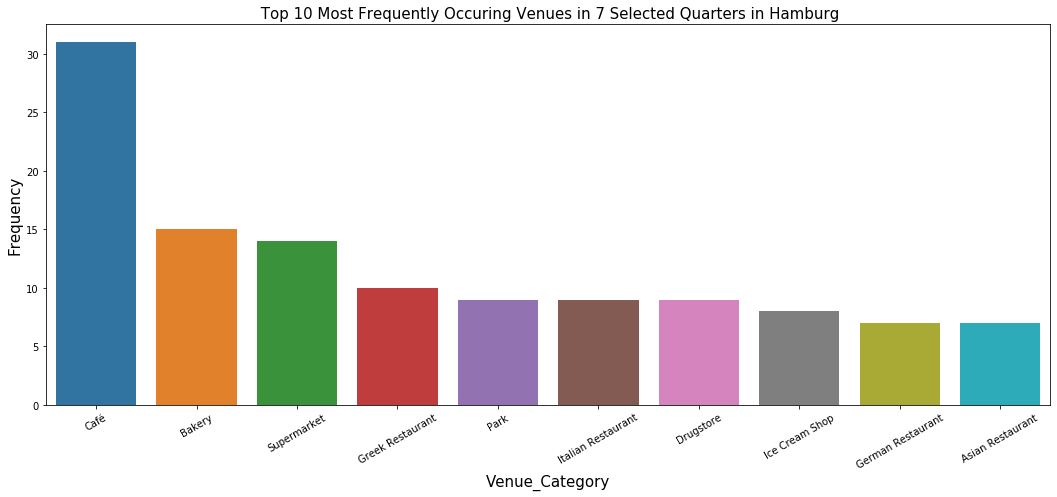

In [82]:
import seaborn as sns
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue_Category", y="Frequency", data=Hamburg_7Q_Venues_Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title(' Top 10 Most Frequently Occuring Venues in 7 Selected Quarters in Hamburg', fontsize=15)
plt.xlabel("Venue_Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues.png", dpi=300)
plt.show()

### Clustering using K-Means

In [83]:
### Use One Hot Encoding to Get More Information about the Venue Categories 
Hamburg_7Q_Venues_onehot = pd.get_dummies(Hamburg_7Q_Venues[['Venue_Category']], prefix="", prefix_sep="")

### add District column back to dataframe
Hamburg_7Q_Venues_onehot['District'] = Hamburg_7Q_Venues['District'] 
### move Quarter column to the first column
fixed_columns = [Hamburg_7Q_Venues_onehot.columns[-1]] + list(Hamburg_7Q_Venues_onehot.columns[:-1])
Hamburg_7Q_Venues_onehot = Hamburg_7Q_Venues_onehot[fixed_columns]

In [84]:
Hamburg_7Q_Venues_Grouped = Hamburg_7Q_Venues_onehot.groupby('District').mean().reset_index()
Hamburg_7Q_Venues_Grouped.index = np.arange(1, len(Hamburg_7Q_Venues_Grouped)+1)
Hamburg_7Q_Venues_Grouped

,District,American Restaurant,Asian Restaurant,Austrian Restaurant,Bakery,Bank,Bar,Bavarian Restaurant,Beach,Bistro,Bookstore,Brazilian Restaurant,Bridge,Burger Joint,Bus Stop,Café,Candy Store,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Dessert Shop,Doner Restaurant,Drugstore,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food,Food & Drink Shop,Forest,French Restaurant,Furniture / Home Store,Gas Station,Gastropub,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym / Fitness Center,Hardware Store,Hawaiian Restaurant,History Museum,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Lighthouse,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Museum,Music Venue,Neighborhood,Office,Outlet Store,Park,Pharmacy,Pier,Pizza Place,Planetarium,Plaza,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shoe Store,Snack Place,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Taverna,Tea Room,Thai Restaurant,Theater,Track Stadium,Train Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop
1,Blankenese,0.000000,0.000000,0.00,0.026316,0.026316,0.000000,0.026316,0.052632,0.000000,0.00,0.000000,0.000000,0.000000,0.026316,0.131579,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.052632,0.052632,0.00,0.000000,0.026316,0.00,0.000000,0.026316,0.000000,0.000000,0.00,0.00,0.026316,0.000000,0.00,0.026316,0.026316,0.000000,0.052632,0.000000,0.026316,0.000000,0.000000,0.026316,0.000000,0.000000,0.00,0.00,0.052632,0.00,0.000000,0.078947,0.000000,0.026316,0.000000,0.000000,0.000000,0.026316,0.026316,0.026316,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,0.00,0.000000
2,Eimsbüttel,0.000000,0.020000,0.01,0.050000,0.000000,0.050000,0.000000,0.000000,0.000000,0.02,0.010000,0.000000,0.020000,0.000000,0.170000,0.000000,0.000000,0.01,0.000000,0.01,0.03,0.000000,0.000000,0.000000,0.01,0.01,0.01,0.010000,0.000000,0.030000,0.010000,0.010000,0.000000,0.000000,0.01,0.000000,0.020000,0.010000,0.000000,0.000000,0.030000,0.01,0.01,0.040000,0.01,0.030000,0.000000,0.000000,0.000000,0.000000,0.030000,0.01,0.000000,0.030000,0.01,0.000000,0.000000,0.000000,0.000000,0.01,0.01,0.000000,0.000000,0.01,0.000000,0.000000,0.000000,0.040000,0.020000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.02,0.01,0.010000,0.01,0.000000,0.010000,0.000000,0.000000,0.010000,0.000000,0.000000,0.020000,0.020000,0.000000,0.010000,0.000000,0.020000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.01,0.000000
3,Niendorf,0.000000,0.041667,0.00,0.041667,0.041667,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,0.00,0.041667,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.041667,0.000000,0.041667,0.041667,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.125000,0.00,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.083333,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.041667,0.00,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,0.208333,0.000000,0.000000,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
4,Rahlstedt,0.047619,0.000000,0.00,0.238095,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0

In [85]:
num_top_venues = 5 
# Finding the opt 5 Venue in each selected District (=Quarter). 
# Note that the returned data from Foursquare API name "Quarter" as "District". I'll use "District" from Foursquare data.

for places in Hamburg_7Q_Venues_Grouped['District']:
    print("======= "+places+" =======")
    temp = Hamburg_7Q_Venues_Grouped[Hamburg_7Q_Venues_Grouped['District'] == places].T.reset_index()
    temp.columns = ['Venue','Freq']
    temp = temp.iloc[1:]
    temp['Freq'] = temp['Freq'].astype(float)
    temp = temp.round({'Freq': 2})
    print(temp.sort_values('Freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

======= Blankenese =======
                Venue  Freq
0                Café  0.13
1  Seafood Restaurant  0.08
2      Ice Cream Shop  0.05
3               Hotel  0.05
4            Tea Room  0.05


======= Eimsbüttel =======
              Venue  Freq
0              Café  0.17
1            Bakery  0.05
2               Bar  0.05
3  Greek Restaurant  0.04
4              Park  0.04


======= Niendorf =======
                Venue  Freq
0         Supermarket  0.21
1    Greek Restaurant  0.12
2  Italian Restaurant  0.08
3          Restaurant  0.04
4      Hardware Store  0.04


======= Rahlstedt =======
                   Venue  Freq
0                 Bakery  0.24
1              Drugstore  0.10
2    American Restaurant  0.05
3         Clothing Store  0.05
4  Vietnamese Restaurant  0.05


======= Sasel =======
              Venue  Freq
0  Asian Restaurant  0.14
1       Supermarket  0.14
2         Wine Shop  0.07
3           Taverna  0.07
4         Gastropub  0.07


======= Volksdorf =======
   

In [86]:
## Define a Function to select the top 10 rows (According to the Values) 

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Hamburg_7Q_Venues_Top10_sorted = pd.DataFrame(columns=columns)
Hamburg_7Q_Venues_Top10_sorted['District'] = Hamburg_7Q_Venues_Grouped['District']

for ind in np.arange(Hamburg_7Q_Venues_Grouped.shape[0]):
    Hamburg_7Q_Venues_Top10_sorted.iloc[ind, 1:] = return_most_common_venues(Hamburg_7Q_Venues_Grouped.iloc[ind, :], num_top_venues)

    
Hamburg_7Q_Venues_Top10_sorted.index = np.arange(1, len(Hamburg_7Q_Venues_Top10_sorted)+1)
Hamburg_7Q_Venues_Top10_sorted.head(7)

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Blankenese,Café,Seafood Restaurant,Tea Room,Park,Restaurant,Ice Cream Shop,Beach,Hotel,Bavarian Restaurant,Bakery
2,Eimsbüttel,Café,Bakery,Bar,Park,Greek Restaurant,Ice Cream Shop,Coffee Shop,Gym / Fitness Center,Italian Restaurant,Drugstore
3,Niendorf,Supermarket,Greek Restaurant,Italian Restaurant,Hardware Store,Pizza Place,Drugstore,Farmers Market,Fast Food Restaurant,Clothing Store,Restaurant
4,Rahlstedt,Bakery,Drugstore,Hotel,Supermarket,Bus Stop,Clothing Store,Farmers Market,Fast Food Restaurant,German Restaurant,Ice Cream Shop
5,Sasel,Asian Restaurant,Supermarket,Wine Shop,Taverna,Dessert Shop,Farmers Market,Food,Bus Stop,Furniture / Home Store,Gastropub
6,Volksdorf,Gas Station,Supermarket,American Restaurant,Steakhouse,History Museum,Greek Restaurant,Ice Cream Shop,Indie Movie Theater,German Restaurant,Forest
7,Winterhude,Café,Park,Bus Stop,Italian Restaurant,German Restaurant,Drugstore,Greek Restaurant,Sushi Restaurant,Convenience Store,Metro Station


In [87]:
# set number of clusters
kclusters = 4

HH_grouped_clustering = Hamburg_7Q_Venues_Grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(HH_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:4] 

array([0, 0, 2, 3], dtype=int32)

In [88]:
# add clustering labels

Hamburg_7Q_Venues_Top10_sorted.insert(0, 'Cluster Label', kmeans.labels_)
Hamburg_7Q_Coordinate_Cluster_merged = Quarter_selected

# merge the inital dataframe with Sorted Most Visited places for each neighborhood

Hamburg_7Q_Coordinate_Cluster_merged = Hamburg_7Q_Coordinate_Cluster_merged.join \
                                        (Hamburg_7Q_Venues_Top10_sorted.set_index('District'), on='Quarter')

Hamburg_7Q_Coordinate_Cluster_merged.head(7)

,Quarter,Borough,Population,Density(Population/km²),Coordinates,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Blankenese,Altona,13.686,1777,"(53.5575, 9.80306)",53.557500,9.803060,0,Café,Seafood Restaurant,Tea Room,Park,Restaurant,Ice Cream Shop,Beach,Hotel,Bavarian Restaurant,Bakery
1,Eimsbüttel,Eimsbüttel,58.196,17635,"(53.5724835, 9.9501)",53.572483,9.950100,0,Café,Bakery,Bar,Park,Greek Restaurant,Ice Cream Shop,Coffee Shop,Gym / Fitness Center,Italian Restaurant,Drugstore
2,Niendorf,Eimsbüttel,40.717,3284,"(53.6284111, 9.9557091)",53.628411,9.955709,2,Supermarket,Greek Restaurant,Italian Restaurant,Hardware Store,Pizza Place,Drugstore,Farmers Market,Fast Food Restaurant,Clothing Store,Restaurant
3,Winterhude,Hamburg-Nord,55.900,7355,"(53.5963901, 10.0038317)",53.596390,10.003832,0,Café,Park,Bus Stop,Italian Restaurant,German Restaurant,Drugstore,Greek Restaurant,Sushi Restaurant,Convenience Store,Metro Station
4,Sasel,Wandsbek,23.778,2831,"(53.6522, 10.1169)",53.652200,10.116900,1,Asian Restaurant,Supermarket,Wine Shop,Taverna,Dessert Shop,Farmers Market,Food,Bus Stop,Furniture / Home Store,Gastropub
5,Volksdorf,Wandsbek,20.863,1799,"(53.6485554, 10.1647514)",53.648555,10.164751,2,Gas Station,Supermarket,American Restaurant,Steakhouse,History Museum,Greek Restaurant,Ice Cream Shop,Indie Movie Theater,German Restaurant,Forest
6,Rahlstedt,Wandsbek,91.740,3449,"(53.6038827, 10.1581547)",53.603883,10.158155,3,Bakery,Drugstore,Hotel,Supermarket,Bus Stop,Clothing Store,Farmers Market,Fast Food Restaurant,German Restaurant,Ice Cream Shop


In [89]:
# create map
map_clusters = folium.Map(location=[Hamburg_latitude, Hamburg_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Hamburg_7Q_Coordinate_Cluster_merged['Latitude'], 
                                  Hamburg_7Q_Coordinate_Cluster_merged['Longitude'], 
                                  Hamburg_7Q_Coordinate_Cluster_merged['Quarter'], 
                                  Hamburg_7Q_Coordinate_Cluster_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7
       ).add_to(map_clusters)
       
map_clusters

## Analysis <a name="analysis"></a>

#### Explore the 4 Clusters

 ##### == Cluster 0 ==

In [90]:
Hamburg_Cluster0 = Hamburg_7Q_Coordinate_Cluster_merged.loc[Hamburg_7Q_Coordinate_Cluster_merged['Cluster Label'] == 0, 
                                    Hamburg_7Q_Coordinate_Cluster_merged.columns[[3] + list(range(4, Hamburg_7Q_Coordinate_Cluster_merged.shape[1]))]]
print ("No of Neighbourhood in Cluster Label 0: %d" %(Hamburg_Cluster0.shape[0]))
Hamburg_Cluster0

No of Neighbourhood in Cluster Label 0: 3


,Density(Population/km²),Coordinates,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1777,"(53.5575, 9.80306)",53.557500,9.803060,0,Café,Seafood Restaurant,Tea Room,Park,Restaurant,Ice Cream Shop,Beach,Hotel,Bavarian Restaurant,Bakery
1,17635,"(53.5724835, 9.9501)",53.572483,9.950100,0,Café,Bakery,Bar,Park,Greek Restaurant,Ice Cream Shop,Coffee Shop,Gym / Fitness Center,Italian Restaurant,Drugstore
3,7355,"(53.5963901, 10.0038317)",53.596390,10.003832,0,Café,Park,Bus Stop,Italian Restaurant,German Restaurant,Drugstore,Greek Restaurant,Sushi Restaurant,Convenience Store,Metro Station


 ##### == Cluster 1 ==

In [91]:
Hamburg_Cluster1 = Hamburg_7Q_Coordinate_Cluster_merged.loc[Hamburg_7Q_Coordinate_Cluster_merged['Cluster Label'] == 1, 
                                    Hamburg_7Q_Coordinate_Cluster_merged.columns[[3] + list(range(4, Hamburg_7Q_Coordinate_Cluster_merged.shape[1]))]]
print ("No of Neighbourhood in Cluster Label 1: %d" %(Hamburg_Cluster1.shape[0]))
Hamburg_Cluster1

No of Neighbourhood in Cluster Label 1: 1


,Density(Population/km²),Coordinates,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,2831,"(53.6522, 10.1169)",53.6522,10.1169,1,Asian Restaurant,Supermarket,Wine Shop,Taverna,Dessert Shop,Farmers Market,Food,Bus Stop,Furniture / Home Store,Gastropub


 ##### == Cluster 2 ==

In [92]:
Hamburg_Cluster1 = Hamburg_7Q_Coordinate_Cluster_merged.loc[Hamburg_7Q_Coordinate_Cluster_merged['Cluster Label'] == 2, 
                                    Hamburg_7Q_Coordinate_Cluster_merged.columns[[3] + list(range(4, Hamburg_7Q_Coordinate_Cluster_merged.shape[1]))]]
print ("No of Neighbourhood in Cluster Label 2: %d" %(Hamburg_Cluster1.shape[0]))
Hamburg_Cluster1

No of Neighbourhood in Cluster Label 2: 2


,Density(Population/km²),Coordinates,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,3284,"(53.6284111, 9.9557091)",53.628411,9.955709,2,Supermarket,Greek Restaurant,Italian Restaurant,Hardware Store,Pizza Place,Drugstore,Farmers Market,Fast Food Restaurant,Clothing Store,Restaurant
5,1799,"(53.6485554, 10.1647514)",53.648555,10.164751,2,Gas Station,Supermarket,American Restaurant,Steakhouse,History Museum,Greek Restaurant,Ice Cream Shop,Indie Movie Theater,German Restaurant,Forest


 ##### == Cluster 3 ==

In [93]:
Hamburg_Cluster1 = Hamburg_7Q_Coordinate_Cluster_merged.loc[Hamburg_7Q_Coordinate_Cluster_merged['Cluster Label'] == 3, 
                                    Hamburg_7Q_Coordinate_Cluster_merged.columns[[3] + list(range(4, Hamburg_7Q_Coordinate_Cluster_merged.shape[1]))]]
print ("No of Neighbourhood in Cluster Label 3: %d" %(Hamburg_Cluster1.shape[0]))
Hamburg_Cluster1

No of Neighbourhood in Cluster Label 3: 1


,Density(Population/km²),Coordinates,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,3449,"(53.6038827, 10.1581547)",53.603883,10.158155,3,Bakery,Drugstore,Hotel,Supermarket,Bus Stop,Clothing Store,Farmers Market,Fast Food Restaurant,German Restaurant,Ice Cream Shop


## Results and Discussion <a name="results"></a>

In this project I examined the different districts of Hamburg and chose the recently available housing objects for sale and their districts compared with the living quality of each districts. The data using the Foursquare API shows the most common venue in the chosen districts. Further data sources are the statistics office of Germany, Wikipedia and Immoscout website with housing ads. By using neighborhood segmentation methods such as kmeans, here are the primary results:

- Cafés are the most common venues in the selected quarters, which followed by bakeries and supermarkets.

- The cluster of Blankenese, Winterhude and Eimbüttel is dominated by Cafés as the most common venue, which also reflects the popularity of these areas for Hamburg dewellers. These three quarters have two of the highest average price per square meter (€/m²) in Hamburg. 

- It's interesting to discover Sasel from the data science perspective. Sasel has the most streets which are labeled with "good" living quality by the German Statistics office in Hamburg. However, the most common venue in Sasel is Asian restaurant, which may indicate that Asian immigrants favor Sasel or there is a strong customer group for Asian food. It is also surprising that the average price (€/m²) of Sasel outdid Eimsbüttel, which is very desirable like Blankenese and Winterhude. In respect of Sasel's rear position of Hamburg metropolitan area, it might be interesting to investigate the population characteristics in Sasel.

- Volksdorf and Niendorf are clustered together based on the common venues, which could be "supermarket" in the top 3 common venue list. However, Niendorf has almost twice population density than Volksdorf. The living quality is more or less the same, but Volksdorf has more housing objects available on the real estate market.

- Rahlstedt is still developing among other districts. The most common venue in Rahlstedt is bakery and even supermarkets are the fourth common venue. It also has the lowest average price per square meter but has the highest number of housing objects for sale in Hamburg. Rahlstedt might have the potential to grow in the future.


According to this analysis, it might be rewarding to invest in Rahlstedt, since it has currently the most available housing objects in the market and the lowest average price per square meter in Hamburg. Meanwhile, Sasel seems to be a potential quarter to dwell in, especially if you are an Asian immigrant. The greater Hamburg is divided by the lake Alster in the middle and people usually favor the west side of Hamburg than the east side. Eimsbüttel is surprisingly affordable in the cluster of Winterhude or Blankenese. However, the average price per square meter in Eimsbüttel is approximately the half of the Winterhude housing objects for sales and lower than price of Sasel. For people who tend to live closer to city center, Eimsbüttel could be a great choice.

The discussion above could only provide a preliminary information about the quarters selected. It still lack more details about each quarters, for example the major industry within each quarter or population constellation. However, it offers an insight to answer the question I posed at the beginning. Given more details, one can even more clustering techniques which are not limited to common venues data from Foursquare API. 

## Conclusion <a name="conclusion"></a>

It is a great learning journey to reach this final capstone project. It is more than trouble shooting and googling the python library documentation. After some trial and error rounds, I abandoned the idea of using Beautiful Soup and simply use the panda read_html. The data cleaning with real data from the German Statistics Office was very painful and I am certainly appreciate every kind of data cleaned for further use. However, the analysis I made might provide a peak view of the current real estate market in Hamburg. Now we know that Rahlstedt is a potential investment object and Eimsbüttel is not as expensive as Winterhude or Blankenese. Sasel seems to be a good balance between good living quality and potential growth in the future. For young families with more purchasing budget, Eimbüttel is still attractive to be settled in. For bigger families, Sasel and Rahlsteht might be a good choice, since the outback of Sasel and Rahlstedt could grow in the future and leaves more room for bigger families, since they are not so crowded in population in Eimsbüttel.

The data I gathered for this capstone project is somehow constricted to using the Foursquare API data and its common venue features. It might be interesting to gather more data such as education systems and reviews of infrastructures within the quarters selected in Hamburg. The real estate market in Hamburg fluctuates and every week there are new housing objects sold and available on the markets. If we could do an longitudinal study on the volatile real estate market in Hamburg, we may gather a broader picture of the development in each quarter in Hamburg, Germany.

Thanks for bearing with me on this capstone project. Now it's time to put this project aside and catch up with the summer time in Hamburg with a glass of Aperol Spritz at the lake Alster. Enjoy!

<img src="https://cdn.pixabay.com/photo/2017/07/18/08/07/aperol-spritz-2515122_1280.jpg" alt="drawing" width="400" height="600"/>